# Step 1 - Install Required Libraries

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not current

In [7]:
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q trl xformers wandb datasets einops gradio sentencepiece bitsandbytes

In [9]:
# !pip install transformers==4.31.0

# Step 2 - Import all the libraries

In [2]:
# peft library - it uses techniques which will try to  freezing most of the weights
# of the llm models when we perform transfer learing on llm models and only some of the
# weights will be retrained. Based on that, they will be able to provide you accurate results
# based on your custom dataset

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

from peft import LoraConfig, PeftModel
from trl import SFTTrainer


The following prompt template is used for the Chat models in case of Llam2

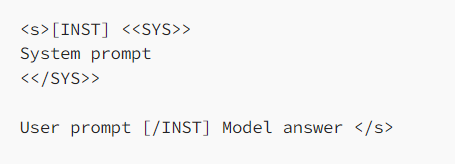

# We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

- To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

# **How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)
- We also need to consider the overhead due to optimizer states, gradients, and forward activations
- Full fine-tuning is not possible here: we need **parameter-efficient fine-tuning (PEFT) techniques** like LoRA or QLoRA.
- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.


# **Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [3]:
!pip install -q xformers wandb einops gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Check the system configurations

In [4]:
import os,torch, wandb, platform, gradio, warnings

In [5]:
def print_system_specs():
    # Check if CUDA is available
    is_cuda_available = torch.cuda.is_available()
    print("CUDA Available:", is_cuda_available)
# Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_cuda_devices)
    if is_cuda_available:
        for i in range(num_cuda_devices):
            # Get CUDA device properties
            device = torch.device('cuda', i)
            print(f"--- CUDA Device {i} ---")
            print("Name:", torch.cuda.get_device_name(i))
            print("Compute Capability:", torch.cuda.get_device_capability(i))
            print("Total Memory:", torch.cuda.get_device_properties(i).total_memory, "bytes")
    # Get CPU information
    print("--- CPU Information ---")
    print("Processor:", platform.processor())
    print("System:", platform.system(), platform.release())
    print("Python Version:", platform.python_version())
print_system_specs()

CUDA Available: True
Number of CUDA devices: 1
--- CUDA Device 0 ---
Name: Tesla T4
Compute Capability: (7, 5)
Total Memory: 15835660288 bytes
--- CPU Information ---
Processor: x86_64
System: Linux 6.1.85+
Python Version: 3.10.12


# **Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [6]:
# Pre trained model
model_name = "meta-llama/Llama-2-7b-hf"

# Dataset name
dataset_name = "vicgalle/alpaca-gpt4"

# Hugging face repository link to save fine-tuned model(Create new repository in huggingface,copy and paste here)
new_model = "Llama-2-7b-chat-finetune"

In [7]:
from huggingface_hub import notebook_login
notebook_login()

In [8]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train[0:10000]")
dataset["text"][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'

In [9]:
# Load base model(llama-2-7b-hf) and tokenizer
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model


bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
model = prepare_model_for_kbit_training(model)
model.config.use_cache = False # silence the warnings. Please re-enable for inference!
model.config.pretraining_tp = 1
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

(True, True)

In [11]:
#monitering login
wandb.login(key="43b575c7049ee149399e79ea0b25d87836e2e9ea")
run = wandb.init(project='Fine tuning llama-2-7B', job_type="training", anonymous="allow")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saikumarseela (saikumarseela-vasireddy-venkatadri-institute-of-technology). Use `wandb login --relogin` to force relogin


In [12]:
peft_config = LoraConfig(
    lora_alpha= 8,
    lora_dropout= 0.1,
    r= 16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

In [13]:
training_arguments = TrainingArguments(
    output_dir= "./results",
    num_train_epochs= 1,
    per_device_train_batch_size= 8,
    gradient_accumulation_steps= 2,
    optim = "paged_adamw_8bit",
    save_steps= 1000,
    logging_steps= 30,
    learning_rate= 2e-4,
    weight_decay= 0.001,
    fp16= False,
    bf16= False,
    max_grad_norm= 0.3,
    max_steps= -1,
    warmup_ratio= 0.3,
    group_by_length= True,
    lr_scheduler_type= "linear",
    report_to="wandb",
)

In [14]:
# Setting sft parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length= None,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 76.4 seconds.), retrying request
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [15]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  stacklevel=2
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 140.0 seconds.), retrying request


Step,Training Loss
30,1.335000
60,1.201400
90,0.859000
120,0.816400
150,0.827400
180,0.892800
210,0.747800
240,0.961900
270,0.859300
300,0.778400


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 263.9 seconds.), retrying request


TrainOutput(global_step=625, training_loss=0.864685806274414, metrics={'train_runtime': 7960.0088, 'train_samples_per_second': 1.256, 'train_steps_per_second': 0.079, 'total_flos': 4.5447892058112e+16, 'train_loss': 0.864685806274414, 'epoch': 1.0})

In [32]:
# Save the fine-tuned model
trainer.model.save_pretrained(new_model)
wandb.finish()
model.config.use_cache = True
model.eval()

NameError: name 'trainer' is not defined

In [19]:
from transformers import TextStreamer

def stream(user_prompt):
    runtimeFlag = "cuda:0"
    system_prompt = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n'
    B_INST, E_INST = "### Instruction:\n", "### Response:\n"

    prompt = f"{system_prompt}{B_INST}{user_prompt.strip()}\n\n{E_INST}"

    inputs = tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    _ = model.generate(**inputs, streamer=streamer, max_new_tokens=500)

In [21]:
stream("what is the capital of the Unite Kingdom?")


### Instruction:
What is the capital of the United Kingdom?

### Response:
The capital of the United Kingdom is London. It is a major city and financial center in the United Kingdom. It is located on the River Thames in southeastern England. London is known for its iconic landmarks such as Big Ben, Tower Bridge, and the London Eye. It is also home to several universities, including the prestigious University of London and the London School of Economics. London is a cosmopolitan city, with people from all over the world living and working there. It is a major center for culture, arts, and fashion, with world-class museums, galleries, and theaters. London is also a hub for business and finance, with major banks and corporations headquartered there. Overall, London is a vibrant, diverse, and exciting city that is a must-visit for anyone interested in exploring the United Kingdom.

London is the largest city in the United Kingdom and one of the largest in the world, with a population of o

In [29]:
# Clear the memory footprint
del model, trainer
torch.cuda.empty_cache()

NameError: name 'model' is not defined

In [25]:
import torch
torch.cuda.empty_cache()

In [27]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  14826 MiB |  14826 MiB | 347030 GiB | 347015 GiB |\n|       from large pool |  14510 MiB |  14510 MiB | 346707 GiB | 346693 GiB |\n|       from small pool |    316 MiB |    484 MiB |    322 GiB |    322 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  14826 MiB |  14826 MiB | 347030 GiB | 347015 GiB |\n|       from large pool |  14510 MiB |  14510 MiB |

In [30]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name, low_cpu_mem_usage=True,
    return_dict=True,torch_dtype=torch.float16,
    device_map= {"": 0})
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 250.00 MiB. GPU 

In [31]:
new_model="https://huggingface.co/saikumarofficial/Llama-2-7b-chat-finetune"

model.push_to_hub(new_model)
tokenizer.push_to_hub(new_model)

NameError: name 'model' is not defined